# Residual-Aware RL-MPC
### Visualization of Results (Python/Gymnasium)

**Overview:**
The `MountainCarContinuous-v0` is a classic gym problem for control theory applications and reinforcement learning. The system includes of an underpowered car positioned in a one dimensional sinusoidal valley. The goal is to drive the car to the target flag on top of the right hill.

The physics are highly nonlinear. The dynamics are governed by the equation:
$$v_{t+1} = v_t + \text{force} \times \text{power} - 0.0025 \cos(3 p_t)$$
The main problem is that the maximum engine force is insufficient to overcome the gravity and climb the hill directly. The controller must learn to **swing itself up**, which is basically consequently moving away from the goal for a distance to gain potential energy before accelerating forward.
* **Observation:** $S = [ \text{position}, \text{velocity} ]$, where $p \in [-1.2, 0.6]$ and $v \in [-0.07, 0.07]$.
* **Action:** $A = [ \text{force} ]$, continuous value in $[-1.0, 1.0]$.

In [1]:
from graphviz import Digraph
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import os

## 1. Baseline MPC
As seen in the visualization, the car oscillates at the bottom but fails to reach the flag. It attempts to drive directly toward the goal but lacks the swinging strategy required to overcome gravity.

The MPC controller relies on an **N4SID linear model**.
1.  The linear model ($x_{k+1} = Ax_k + Bu_k$) approximates the dynamics well only in small regions. It fails to capture the general nonlinear geometry($\cos(3p)$ gravity term) required to understand that moving far away from the goal consistently is necessary to gain potential energy.

2.  As the car moves further up the hill, the discrepancy between the linear model and the true nonlinear physics (the **Residual**) increases. Thus creating a **Model Mismatch**.

3.  With fixed weights ($Q, R$), the controller cannot adapt its aggressiveness when the model becomes unreliable. 

This failure validates the main hypothesis of the project: A standard linear MPC is unsuccesfull for this task without a mechanism to adapt to modeling errors. This motivates the design of the **Residual-Aware RL Agent** in the next phase, which will dynamically tune the MPC weights based on the real time residual signals.


##### 1.1 Load MATLAB Simulation Data
In the previous MATLAB step (mpc_without_rl.mlx), we designed a linear MPC controller based on an N4SID identified model. The simulation results (inputs and states) were exported to `mpc_results.mat` file. In this notebook, we replay the control inputs on the official `MountainCarContinuous-v0` Gymnasium environment.

In [2]:
data_path = '../data/mpc_results.mat'
data = scipy.io.loadmat(data_path)

# Flatten the arrays to 1D for iteration
inputs = data['log_u'].flatten()

# We load positions only for validation of the simulation, but we drive the simulation with only the inputs
print(f"Total simulation steps to replay: {len(inputs)}")

Total simulation steps to replay: 300


#### 1.2 Gymnasium Environment Setup & Replay
We initialize the `MountainCarContinuous-v0` environment. The environment is wrapped with `RecordVideo` to save the simulation replay as an `.mp4` file in the `../videos` directory. We override the default random reset to force the exact initial condition used in MATLAB ($x_0 = [-0.5, 0]$).

In [3]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')

# Wrap the environment to record video
video_folder = '../videos'
env = RecordVideo(env, video_folder=video_folder, 
                  episode_trigger=lambda x: True,
                  name_prefix='baseline_mpc_failure')
# Force the exact initial condition used in MATLAB: x0 = [-0.5, 0.0]
obs, info = env.reset(seed=418)
env.unwrapped.state = np.array([-0.5, 0.0]) 
print("Starting Simulation")
for i, u in enumerate(inputs):
    action = np.array([u], dtype=np.float32)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        break

env.close()
print(f"Replay Finished.")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/erincada/Desktop/data_project/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Starting Simulation
Replay Finished.


## 2. Residual-Aware RL-MPC: Validation & Visualization

In this final phase, we visualize the performance of the trained **Residual-Aware RL agent**. Unlike the baseline **Linear MPC**, which failed to overcome the nonlinear gravity effects of the system, the **RL-augmented controller** demonstrates a **swing-up strategy** that successfully drives the system to the target state. The agent dynamically switches between **three distinct control modes** based on the **model residual** $(r_t)$.  
This behavior effectively implements a **gain-scheduling policy**.

### 2.1 Load Simulation Data & Setup
We load the data exported from the final **MATLAB validation run** (`rl_mpc_results.mat`) in order to replay the **exact control sequence** inside the **Gymnasium environment**.


In [4]:
data_path = '../data/rl_mpc_results.mat'
rl_data = scipy.io.loadmat(data_path)

log_y = rl_data['log_y'].flatten()      # Position
log_u = rl_data['log_u'].flatten()      # Control Input
log_r = rl_data['log_r'].flatten()      # Residual
log_mode = rl_data['log_mode'].flatten() # Selected Mode (1, 2, or 3)
time_steps = np.arange(len(log_y))

### 2.2 Video Generation & Final Validation

We render the simulation to visually confirm the **physical validity** of the learned control strategy.


In [5]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')

video_folder = '../videos'
env = RecordVideo(env, video_folder=video_folder, 
                  episode_trigger=lambda x: True,
                  name_prefix='rl_mpc_success')

# Force the same initial condition as MATLAB: x0 = [-0.5, 0.0]
obs, info = env.reset(seed=418)
env.unwrapped.state = np.array([-0.5, 0.0]) 

print("Rendering RL-MPC Solution...")

for i, u in enumerate(log_u):
    action = np.array([u], dtype=np.float32)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or i == len(log_u)-1:
        break

env.close()

Rendering RL-MPC Solution...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/erincada/Desktop/data_project/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### 2.3 Analysis of the Adaptive Switching Strategy

The **"Selected Parameter Set"** graph shows a strategic sequence:

- **Phase 1: Initial Attempt (Mode 2 – Tracking):**  
  The agent starts classically, attempting to drive directly toward the goal.

- **Phase 2: Uncertainty & Pivot (Mode 3 – Stabilize):**  
  As the car fails to climb the right hill, the linear model’s prediction error (**residual**) spikes. The RL agent detects this increased uncertainty and switches to **Mode 3**. This acts as a **safety buffer**.

- **Phase 3: Energy Gathering (Mode 1 – Recovery):**  
  The agent realizes it lacks sufficient momentum and deliberately switches to **Mode 1**, setting the target to the **left wall (-1.2)**. This aggressive negative force drives the car backward, converting motor power into **potential energy** on the left slope.

- **Phase 4: The Transition (Mode 3 – Stabilize):**  
  As the car swings down from the left hill, the dynamics become fast and highly nonlinear. The agent briefly switches back to **Mode 3**, ensuring the car is optimally positioned for the final push.

- **Phase 5: The Launch (Mode 2 – Tracking):**  
  With sufficient kinetic energy accumulated from the swing, the agent switches back to **Mode 2**. The linear MPC now operates within a favorable regime, applying full throttle to successfully reach the flag.


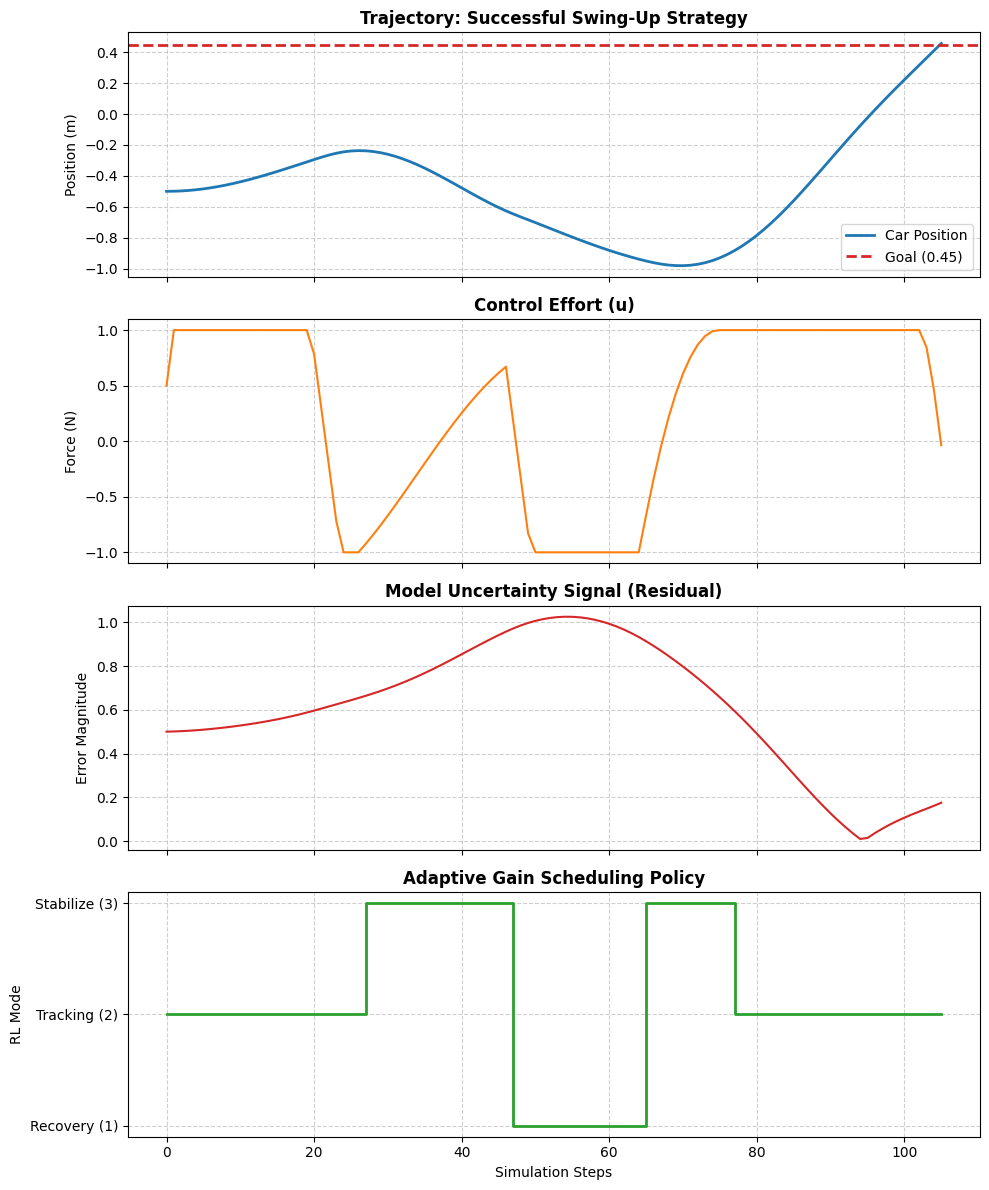

In [6]:
plt.style.use('default')
fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# 1. Position
ax[0].plot(time_steps, log_y, color='tab:blue', linewidth=2, label='Car Position')
ax[0].axhline(0.45, color='tab:red', linestyle='--', linewidth=2, label='Goal (0.45)')
ax[0].set_ylabel('Position (m)')
ax[0].set_title('Trajectory: Successful Swing-Up Strategy', fontweight='bold')
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend(loc='lower right')

# 2. Control Input
ax[1].plot(time_steps, log_u, color='tab:orange', linewidth=1.5)
ax[1].set_ylabel('Force (N)')
ax[1].set_title('Control Effort (u)', fontweight='bold')
ax[1].grid(True, linestyle='--', alpha=0.6)

# 3. Residual
ax[2].plot(time_steps, log_r, color='tab:red', linewidth=1.5)
ax[2].set_ylabel('Error Magnitude')
ax[2].set_title('Model Uncertainty Signal (Residual)', fontweight='bold')
ax[2].grid(True, linestyle='--', alpha=0.6)

# 4. Mode Switching
ax[3].step(time_steps, log_mode, where='post', color='tab:green', linewidth=2)
ax[3].set_yticks([1, 2, 3])
ax[3].set_yticklabels(['Recovery (1)', 'Tracking (2)', 'Stabilize (3)'])
ax[3].set_ylabel('RL Mode')
ax[3].set_xlabel('Simulation Steps')
ax[3].set_title('Adaptive Gain Scheduling Policy', fontweight='bold')
ax[3].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 3. System Architecture Diagram
The following block diagram illustrates the complete project workflow, partitioned into three main phases: Offline Identification, RL Agent Training, and the final Online Residual-Aware Control Loop.

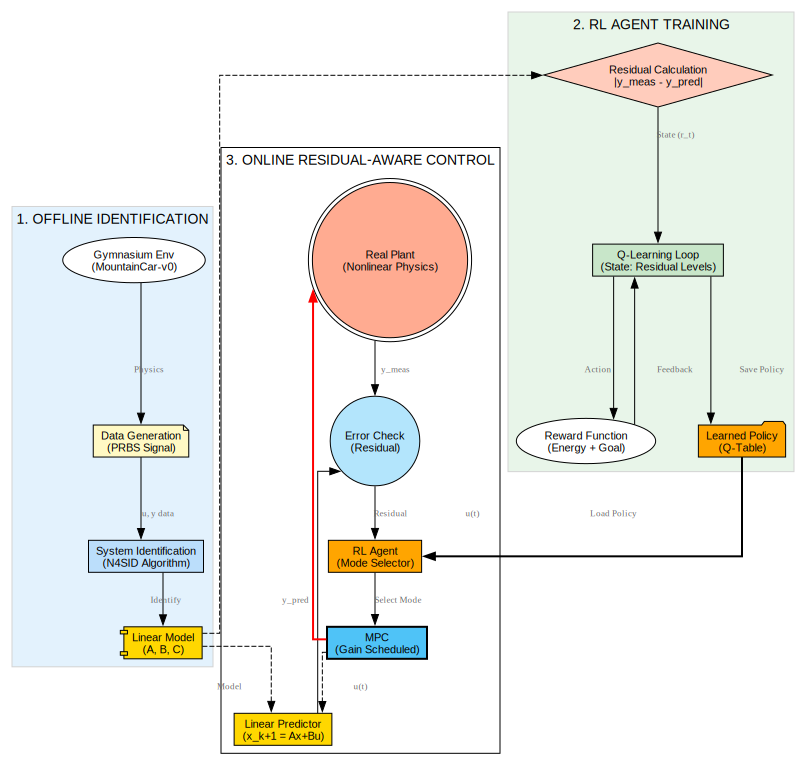

In [7]:
output_dir = '../images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


dot = Digraph('RL_MPC_Compact', comment='Residual-Aware RL-MPC Compact Flow')
dot.attr(rankdir='TB', splines='ortho', nodesep='0.6', ranksep='0.6', fontname='Helvetica')
dot.attr('node', shape='box', style='filled', fontname='Helvetica', fontsize='11', height='0.4')
dot.attr('edge', fontsize='9', fontcolor='dimgrey')

# IDENTIFICATION & DATA
with dot.subgraph(name='cluster_0') as c:
    c.attr(label='1. OFFLINE IDENTIFICATION', style='filled', color='lightgrey', fillcolor='#E3F2FD')
    
    c.node('SimEnv', 'Gymnasium Env\n(MountainCar-v0)', shape='ellipse', fillcolor='white')
    c.node('DataGen', 'Data Generation\n(PRBS Signal)', shape='note', fillcolor='#FFF9C4')
    c.node('N4SID', 'System Identification\n(N4SID Algorithm)', fillcolor='#BBDEFB')
    c.node('LinearModel', 'Linear Model\n(A, B, C)', shape='component', fillcolor='gold')
    
    c.edge('SimEnv', 'DataGen', label='Physics')
    c.edge('DataGen', 'N4SID', label='u, y data')
    c.edge('N4SID', 'LinearModel', label='Identify')

# RL
with dot.subgraph(name='cluster_1') as c:
    c.attr(label='2. RL AGENT TRAINING', style='filled', color='lightgrey', fillcolor='#E8F5E9')
    
    c.node('ResidualCalc', 'Residual Calculation\n|y_meas - y_pred|', shape='diamond', fillcolor='#FFCCBC')
    c.node('RL_Loop', 'Q-Learning Loop\n(State: Residual Levels)', fillcolor='#C8E6C9')
    c.node('Reward', 'Reward Function\n(Energy + Goal)', shape='ellipse', fillcolor='white')
    c.node('QTable', 'Learned Policy\n(Q-Table)', shape='folder', fillcolor='orange')
    
    c.edge('ResidualCalc', 'RL_Loop', label='State (r_t)')
    c.edge('RL_Loop', 'Reward', label='Action')
    c.edge('Reward', 'RL_Loop', label='Feedback')
    c.edge('RL_Loop', 'QTable', label='Save Policy')

# RL-MPC
with dot.subgraph(name='cluster_2') as c:
    c.attr(label='3. ONLINE RESIDUAL-AWARE CONTROL', style='filled', color='black', fillcolor='white')
    
    c.node('RealPlant', 'Real Plant\n(Nonlinear Physics)', shape='doublecircle', fillcolor='#FFAB91')
    c.node('Estimator', 'Linear Predictor\n(x_k+1 = Ax+Bu)', shape='box', fillcolor='gold')
    c.node('Comparator', 'Error Check\n(Residual)', shape='circle', width='0.8', fillcolor='#B3E5FC')
    c.node('Agent', 'RL Agent\n(Mode Selector)', fillcolor='orange')
    c.node('MPC', 'MPC\n(Gain Scheduled)', style='filled', fillcolor='#4FC3F7', penwidth='2')
    
    c.edge('RealPlant', 'Comparator', label='y_meas')
    c.edge('Estimator', 'Comparator', label='y_pred')
    c.edge('Comparator', 'Agent', label='Residual')
    c.edge('Agent', 'MPC', label='Select Mode')
    c.edge('MPC', 'RealPlant', label='u(t)', color='red', penwidth='2.0')
    c.edge('MPC', 'Estimator', label='u(t)', style='dashed')

# Global Connections
dot.edge('LinearModel', 'Estimator', style='dashed', label='Model')
dot.edge('LinearModel', 'ResidualCalc', style='dashed', constraint='false')
dot.edge('QTable', 'Agent', style='bold', label='Load Policy')

output_path = os.path.join(output_dir, 'rl_mpc_workflow')
dot.render(output_path, format='png', cleanup=True)
dot